In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
#Loading the uploaded files
file_2013 = "./data/ebird_data_wessan_2013_2014.csv"
file_2023 = "./data/ebird_data_wessan_2023_2024.csv"

df13 = pd.read_csv(file_2013)
df23 = pd.read_csv(file_2023)

#Checking for null values in data
print(f"Null values df13: \n{df13.isnull().sum()}")
print(f"\nNull values df23: \n{df23.isnull().sum()}")

Null values df13: 
subId                0
lat                  0
locationPrivate      0
locName              0
obsDt                0
sciName              0
howMany            145
locId                0
obsValid             0
speciesCode          0
obsReviewed          0
lng                  0
comName              0
dtype: int64

Null values df23: 
sciName             0
comName             0
locName             0
obsReviewed         0
obsValid            0
obsDt               0
lat                 0
howMany            78
subId               0
locationPrivate     0
lng                 0
speciesCode         0
locId               0
dtype: int64


In [4]:
df13.howMany = df13.howMany.fillna(1)
df23.howMany = df23.howMany.fillna(1)

In [5]:
total_birds_13 = df13.howMany.sum()
total_birds_23 = df23.howMany.sum()

print("Total birds observed 2013–14:", total_birds_13)
print("Total birds observed 2023–24:", total_birds_23)

Total birds observed 2013–14: 192869.0
Total birds observed 2023–24: 122038.0


## Grid Clustering

In [6]:
# Seeing how many nodes we have have
# Converting the latitudes and longitudes into grids of size 2 degree
GRID_SIZE = 2.0

def assign_grid(df, size):
    df = df.copy()
    df["grid_lat"] = (df.lat / size).round().astype(int)
    df["grid_lng"] = (df.lng / size).round().astype(int)
    df["grid_cell"] = list(zip(df["grid_lat"], df["grid_lng"]))
    return df

In [7]:
df13g = assign_grid(df13, GRID_SIZE)
df23g = assign_grid(df23, GRID_SIZE)

print("\nGrid nodes:")
print("Number of nodes 2013–14:", df13g.grid_cell.nunique())
print("Number of nodes 2023–24:", df23g.grid_cell.nunique())


Grid nodes:
Number of nodes 2013–14: 82
Number of nodes 2023–24: 81


In [8]:
df23g.grid_cell

0       (17, -59)
1       (22, -62)
2       (24, -60)
3       (25, -62)
4       (21, -62)
          ...    
1700    (19, -61)
1701    (21, -61)
1702    (24, -60)
1703    (24, -62)
1704    (11, -53)
Name: grid_cell, Length: 1705, dtype: object

In [9]:
grid13 = set(df13g.grid_cell.unique())
grid23 = set(df23g.grid_cell.unique())

common_nodes = grid13.intersection(grid23)
# present in 2013 but missing in 2023
lost_nodes = grid13 - grid23
# appear only in 2023
new_nodes  = grid23 - grid13

print("Common nodes:", len(common_nodes))
print("Nodes only in 2013–14:", len(lost_nodes))
print("Nodes only in 2023–24:", len(new_nodes))

Common nodes: 64
Nodes only in 2013–14: 18
Nodes only in 2023–24: 17


In [10]:
print("Top 10 densest regions (2013–14):")
print(df13g.groupby("grid_cell").howMany.sum().sort_values(ascending=False).head(10))

print("\nTop 10 densest regions (2023–24):")
print(df23g.groupby("grid_cell").howMany.sum().sort_values(ascending=False).head(10))


Top 10 densest regions (2013–14):
grid_cell
(30, -73)    66816.0
(14, -56)    19651.0
(25, -61)    16957.0
(19, -61)    14987.0
(29, -68)    14030.0
(12, -54)    11926.0
(23, -62)     9786.0
(24, -61)     4409.0
(17, -59)     3785.0
(20, -62)     2923.0
Name: howMany, dtype: float64

Top 10 densest regions (2023–24):
grid_cell
(11, -53)    27322.0
(19, -61)    22879.0
(23, -62)    13051.0
(16, -57)     8888.0
(10, -53)     8684.0
(16, -58)     6918.0
(12, -53)     4462.0
(25, -61)     3483.0
(30, -73)     3007.0
(15, -58)     2344.0
Name: howMany, dtype: float64


## KMeans

In [14]:
from sklearn.preprocessing import StandardScaler
locations_13 = df13[["lat", "lng"]]
locations_23 = df23[["lat", "lng"]]

scaler = StandardScaler()
locations_13s = scaler.fit_transform(locations_13)
locations_23s = scaler.fit_transform(locations_23)

In [15]:
scores_13 = []
k_range = range(10, 100)

for k in k_range:
    kmeans_13 = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_13 = kmeans_13.fit_predict(locations_13s)
    score_13 = silhouette_score(locations_13s, labels_13)
    scores_13.append(score_13)

best_k13 = k_range[scores_13.index(max(scores_13))]
print("Optimal k by silhouette:", best_k13)

Optimal k by silhouette: 96


In [16]:
scores_23 = []

for k in k_range:
    kmeans_23 = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_23 = kmeans_23.fit_predict(locations_23s)
    score_23 = silhouette_score(locations_23s, labels_23)
    scores_23.append(score_23)

best_k23 = k_range[scores_23.index(max(scores_23))]
print("Optimal k by silhouette:", best_k23)

Optimal k by silhouette: 94


C:\Users\prffr\AppData\Local\Temp\ipykernel_19688\3807716143.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df13["clusters"] = labels_13
C:\Users\prffr\AppData\Local\Temp\ipykernel_19688\3807716143.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df23["clusters"] = labels_23


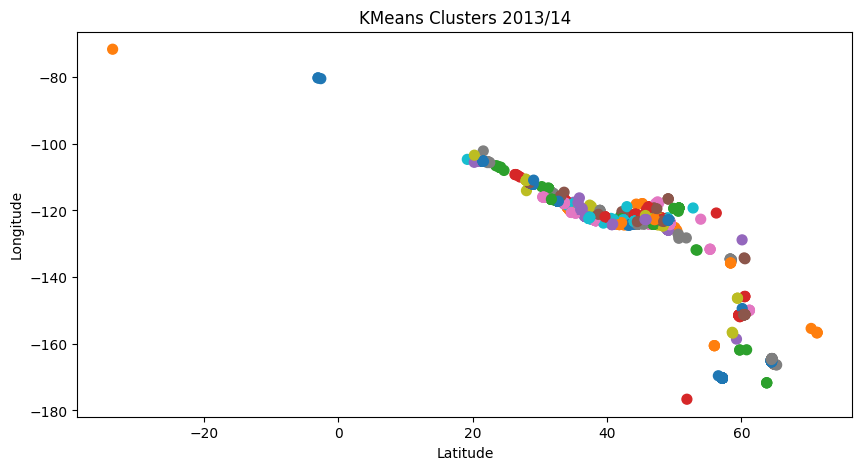

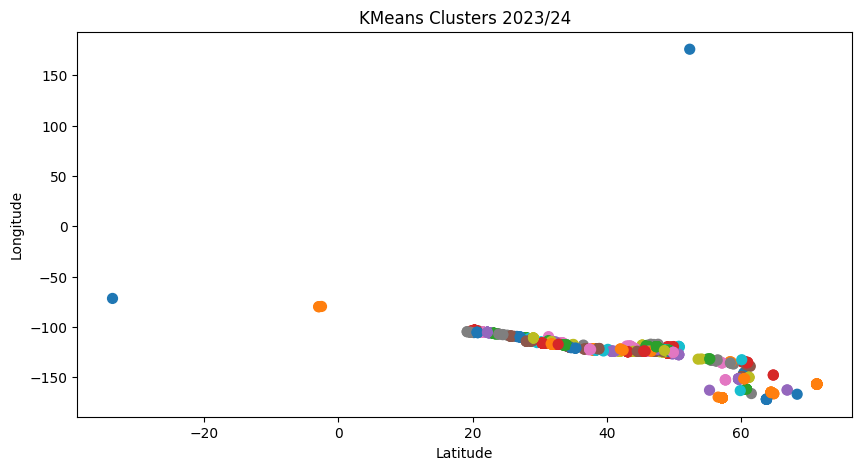

In [17]:
import matplotlib.pyplot as plt


#kmeans13 = KMeans(n_clusters = best_k13)
#y_13 = kmeans13.fit_predict(locations_13)
#
#kmeans23 = KMeans(n_clusters=best_k23)
#y_23 = kmeans23.fit_predict(locations_23)

cluster_df13 = df13[["lat", "lng"]]
cluster_df13["clusters"] = labels_13

cluster_df23 = df23[["lat", "lng"]]
cluster_df23["clusters"] = labels_23

plt.figure(figsize=(10,5))
plt.scatter(cluster_df13["lat"], cluster_df13["lng"], c=cluster_df13["clusters"], cmap='tab10', s = 50)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("KMeans Clusters 2013/14")

plt.figure(figsize=(10,5))
plt.scatter(cluster_df23["lat"], cluster_df23["lng"], c=cluster_df23["clusters"], cmap='tab10', s = 50)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("KMeans Clusters 2023/24")

plt.show()

c:\Users\prffr\Environments\Network Science\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\prffr\Environments\Network Science\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\prffr\Environments\Network Science\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\prffr\Environments\Network Science\venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


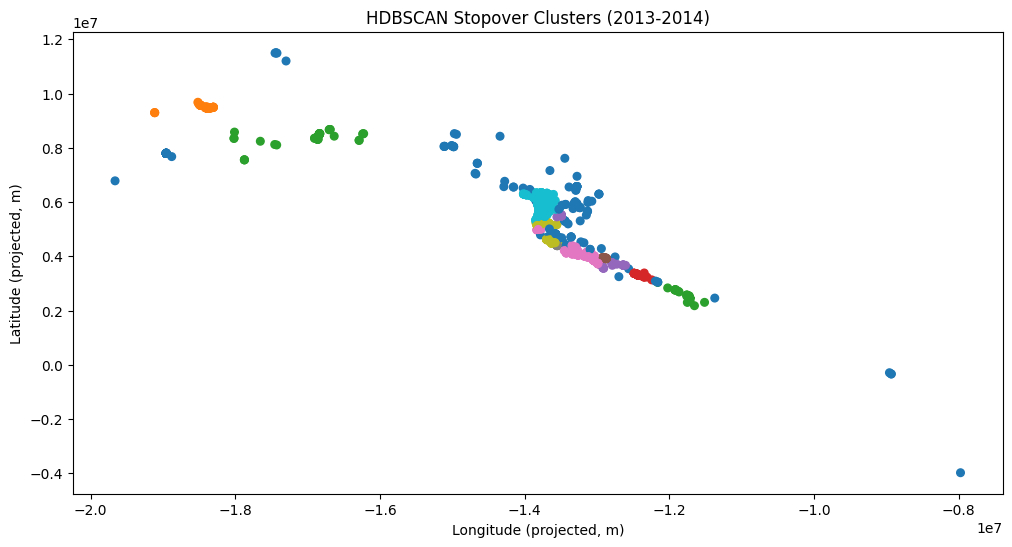

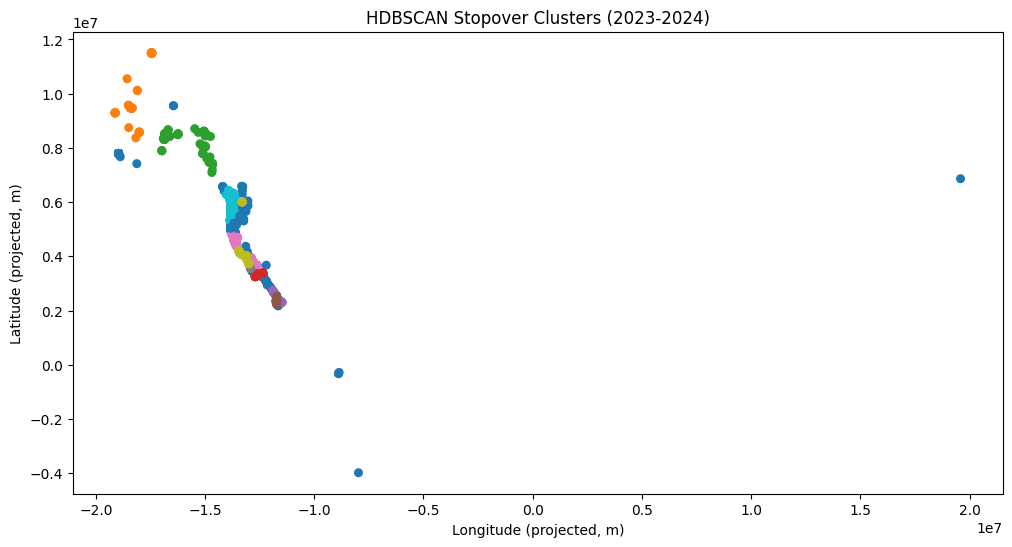

In [30]:
import geopandas as gpd
import hdbscan
import numpy as np
import matplotlib.pyplot as plt

# GeoDataFrame in WGS84
gdf_13 = gpd.GeoDataFrame(
    locations_13,
    geometry=gpd.points_from_xy(locations_13["lng"], locations_13["lat"]),
    crs="EPSG:4326"
)
gdf_23 = gpd.GeoDataFrame(
    locations_23,
    geometry=gpd.points_from_xy(locations_23["lng"], locations_23["lat"]),
    crs="EPSG:4326"
)

# Project to meters
gdf_13_projected = gdf_13.to_crs(epsg=3857)
gdf_23_projected = gdf_23.to_crs(epsg=3857)

# USE PROJECTED COORDINATES (meters)
X_13 = np.vstack([
    gdf_13_projected.geometry.x.values,
    gdf_13_projected.geometry.y.values
]).T
X_23 = np.vstack([
    gdf_23_projected.geometry.x.values,
    gdf_23_projected.geometry.y.values
]).T

coords_rad13 = np.radians(
    np.column_stack([gdf_13["lat"], gdf_13["lng"]])
)

coords_rad23 = np.radians(
    np.column_stack([gdf_23["lat"], gdf_23["lng"]])
)

epsilon_rad = 60000 / 6371000

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=5,
    metric="haversine",
    cluster_selection_epsilon=epsilon_rad
)

labels_13 = clusterer.fit_predict(coords_rad13)
labels_23 = clusterer.fit_predict(coords_rad23)

gdf_13["cluster"] = labels_13
gdf_23["cluster"] = labels_23

# Plot
plt.figure(figsize=(12,6))
plt.scatter(
    gdf_13_projected.geometry.x,
    gdf_13_projected.geometry.y,
    c=gdf_13["cluster"],
    cmap='tab10',
    s=30
)
plt.xlabel("Longitude (projected, m)")
plt.ylabel("Latitude (projected, m)")
plt.title("HDBSCAN Stopover Clusters (2013-2014)")
plt.show()

plt.figure(figsize=(12,6))
plt.scatter(
    gdf_23_projected.geometry.x,
    gdf_23_projected.geometry.y,
    c=gdf_23["cluster"],
    cmap='tab10',
    s=30
)
plt.xlabel("Longitude (projected, m)")
plt.ylabel("Latitude (projected, m)")
plt.title("HDBSCAN Stopover Clusters (2023-2024)")
plt.show()


In [19]:
def normalize_datetime(df):
    #Converting to datetime where possible
    dt = pd.to_datetime(df["obsDt"], errors="coerce")

    # Identifying rows missing a timestamp by matching with regex to look for tt:tt
    has_time = df["obsDt"].str.contains(r"\d{2}:\d{2}", regex=True, na=False)

    #For rows without timestamp appending "00:00:00"
    dt_missing = pd.to_datetime(
        df.loc[~has_time, "obsDt"].astype(str).str.strip() + " 00:00:00",
        errors="coerce"
    )

    #Replace missing-time rows with new midnight timestamps
    dt.loc[~has_time] = dt_missing

    df["dateTime"] = dt
    return df

In [20]:
df13 = normalize_datetime(df13)
df23 = normalize_datetime(df23)


In [21]:
df = df13  # or df23

# 1. Sort by time
df = df.sort_values("dateTime")

# 2. Bin by week
df["week"] = df["dateTime"].dt.isocalendar().week
df["year"] = df["dateTime"].dt.year

# Combine year+week to avoid mixing different years
df["year_week"] = df["year"].astype(str) + "-" + df["week"].astype(str)

# 3. Mean latitude and longitude per week
weekly = df.groupby("year_week")[["lat", "lng"]].mean().reset_index()

# 4. Compute directional movement vectors
weekly["lat_shift"] = weekly["lat"].diff()
weekly["lng_shift"] = weekly["lng"].diff()

print(weekly.head(15))


   year_week        lat         lng  lat_shift  lng_shift
0     2013-1  33.687831 -116.478126        NaN        NaN
1    2013-40  41.664776 -122.689149   7.976946  -6.211022
2    2013-41  40.156921 -120.118656  -1.507855   2.570492
3    2013-42  40.992566 -120.587039   0.835645  -0.468382
4    2013-43  35.357099 -116.971181  -5.635467   3.615857
5    2013-44  38.347954 -120.323892   2.990855  -3.352710
6    2013-45  40.132133 -120.348079   1.784178  -0.024187
7    2013-46  33.454607 -115.356503  -6.677525   4.991576
8    2013-47  37.317212 -118.563684   3.862604  -3.207181
9    2013-48  37.274821 -118.570899  -0.042391  -0.007216
10   2013-49  35.315106 -117.421270  -1.959715   1.149630
11   2013-50  33.514319 -116.400232  -1.800787   1.021037
12   2013-51  32.426426 -115.437079  -1.087893   0.963153
13   2013-52  37.083057 -118.865547   4.656631  -3.428468
14    2014-1  33.740910 -116.401947  -3.342147   2.463600
